In [1]:
%matplotlib notebook
import numpy as np
import pandas
import matplotlib.pyplot as plt

import sedkcorr.sed_fitting.prospector as sedp

In [2]:
sn_name = "CSS110918_02"

data = pandas.read_csv("SNf_mag_3kpc_prospector.dat", sep=' ', index_col='SN_name')
test_data = data.loc[sn_name]
#test_data

In [3]:
test = sedp.ProspectorSEDFitter()

In [4]:
test.load_sps()

In [5]:
test.load_obs(test_data)

In [6]:
test.load_model()

In [7]:
test.run_fit(write_res=False)

dynesty sampling...


iter: 4 | batch: 0 | nc: 1 | ncall: 4 | eff(%):  3.846 | logz: -8036782820.583 +/-  3.316 | dlogz:    inf >  0.050       /anaconda3/lib/python3.6/site-packages/prospect-0.2-py3.6.egg/prospect/fitting/nested.py:76: RuntimeWarning: invalid value encountered in sqrt
iter: 2247 | batch: 0 | nc: 1 | ncall: 21854 | eff(%): 10.282 | logz: 60.527 +/-  0.408 | dlogz:  0.000 >  0.050          


done dynesty (initial) in 463.0683128833771s


iter: 2674 | batch: 1 | nc: 13 | ncall: 26383 | eff(%): 10.190 | loglstar: 76.168 < 78.773 < 78.111 | logz: 60.527 +/-  0.408 | stop:  1.068    

done dynesty (dynamic) in 29.93144392967224s
done dynesty in 493.05977511405945s


In [8]:
test.set_run_params(outfile="test_snf_"+sn_name)

In [9]:
test.write_results()

Could not JSON serialize run_params, pickled instead
Could not JSON serialize model_params, pickled instead


In [10]:
from sedkcorr.k_correction import sed_prospector
import os
DATAPATH = os.path.expanduser(os.getenv('DATAPATH'))

In [11]:
testres = sed_prospector.SED_prospector()

In [12]:
testres.set_data(filename="test_snf_"+sn_name+"_mcmc.h5", data_meas=test_data, sps=test.sps)

<IPython.core.display.Javascript object>


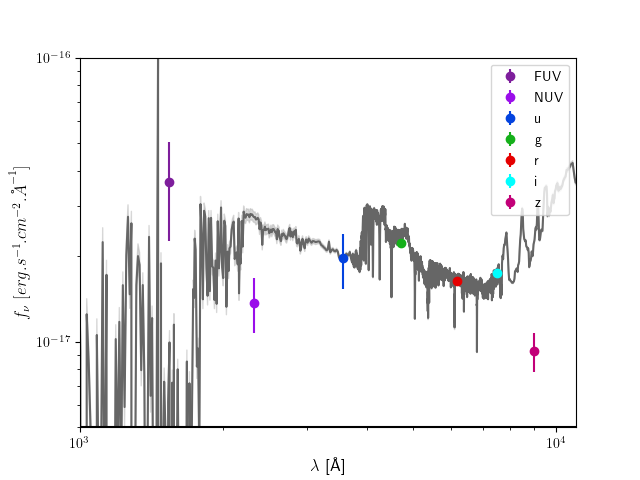

In [13]:
dict_fig = testres.show(y_plot="flux", sed_shifted=False, plot_bandpasses=False, plot_filter_points=True, 
                        xlim=(1000, 11000), ylim=(5e-18, 1e-16), savefile=None, xscale="log", yscale="log", 
                        flux_unit="AA")
dict_fig["ax"].legend(loc="upper right", ncol=1)

<IPython.core.display.Javascript object>


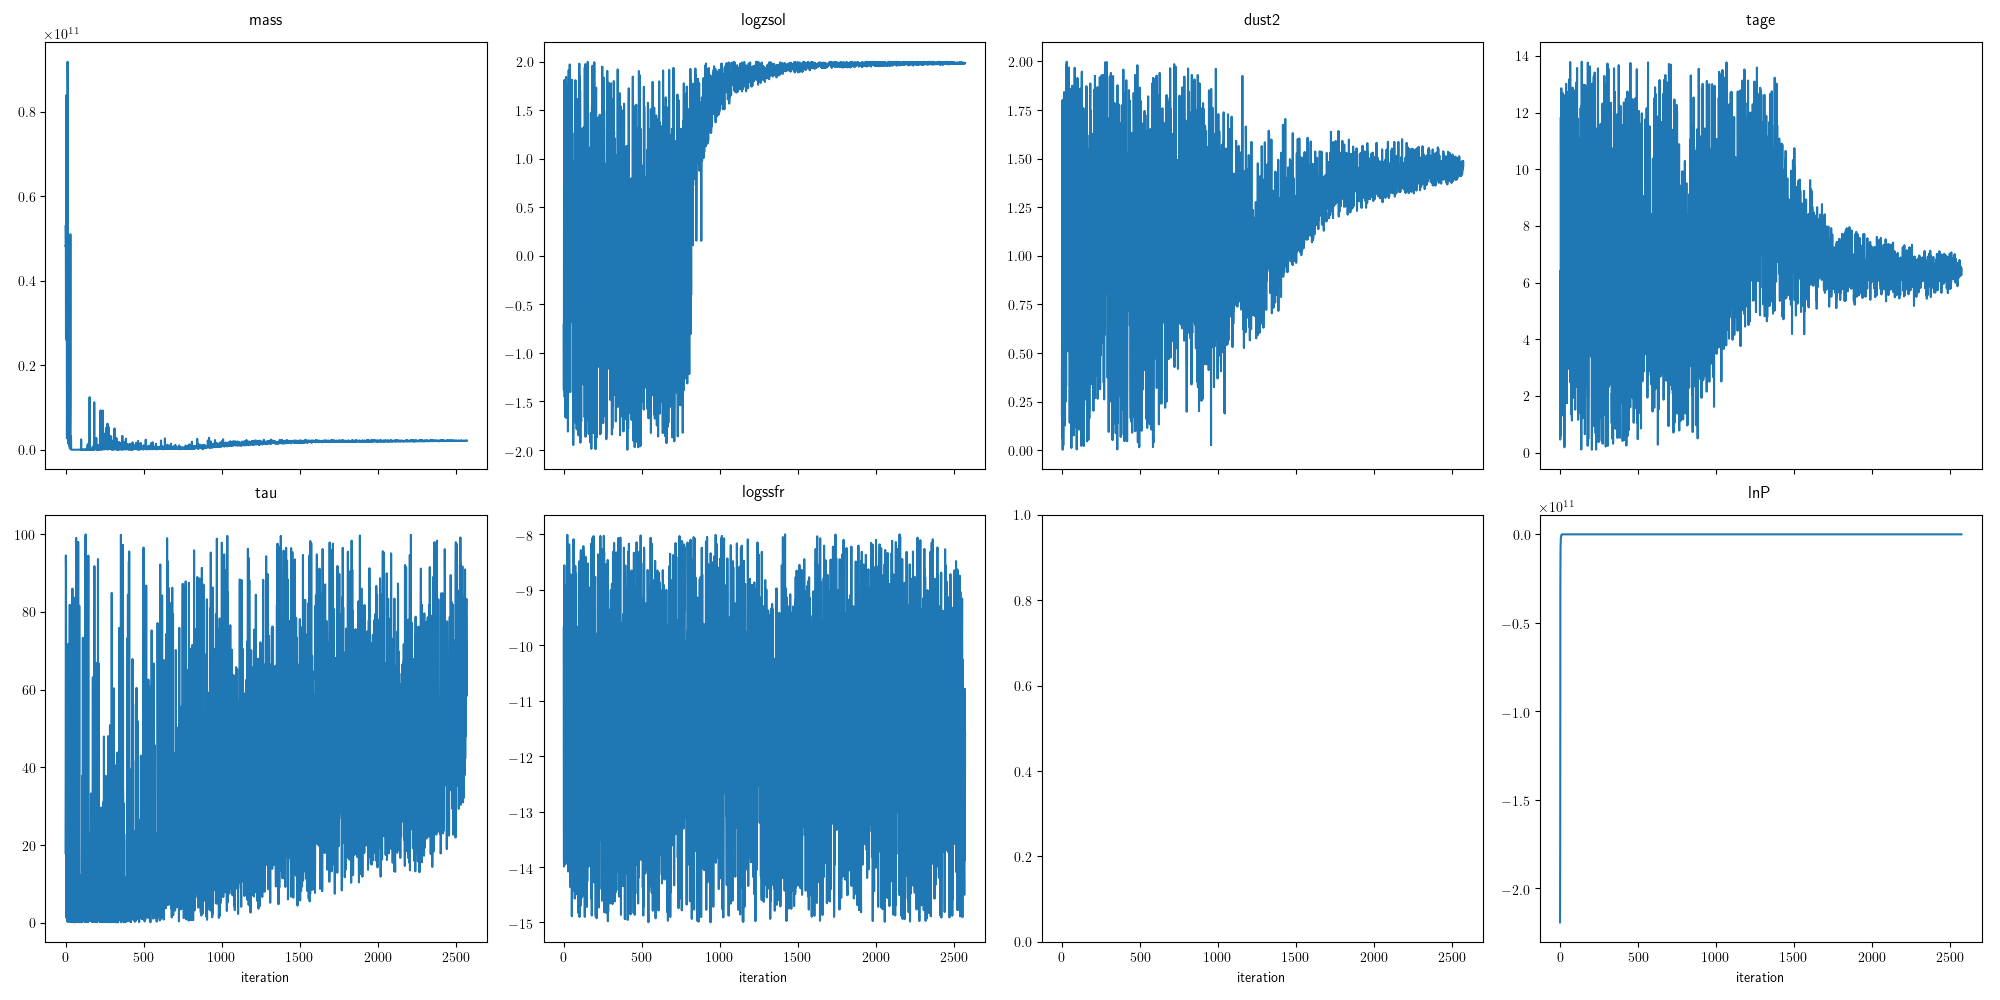

<IPython.core.display.Javascript object>


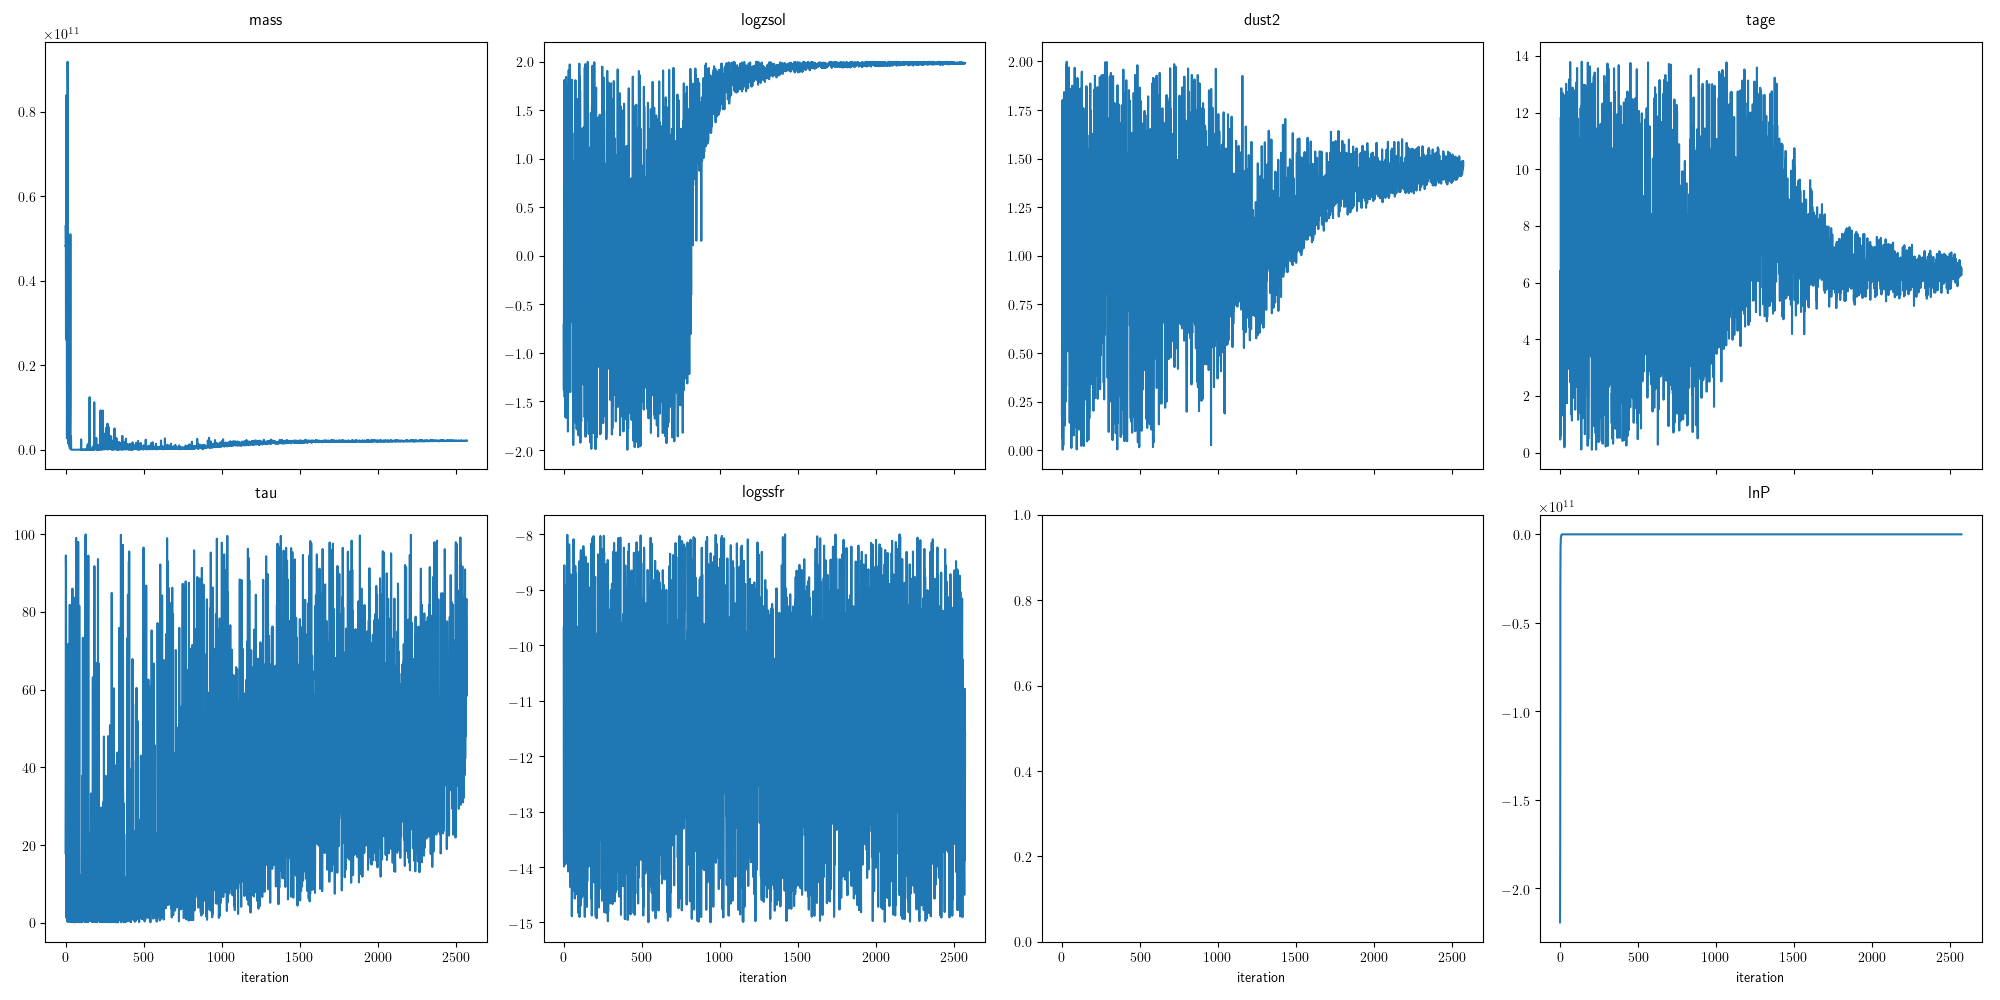

In [14]:
testres.show_walkers()

In [16]:
testkcorr = testres.get_kcorr_error()

In [31]:
np.array(testkcorr)[:,0]

array([3.92722893e-29, 4.56492693e-29, 4.48618534e-29, 4.03797112e-29,
       4.37710439e-29, 4.55321495e-29, 4.33967472e-29, 4.51116438e-29,
       4.62955531e-29, 3.95940631e-29, 4.22350827e-29, 4.25317338e-29,
       4.41699527e-29, 4.42619517e-29, 4.20651653e-29, 4.65998154e-29,
       4.28995150e-29, 4.09187754e-29, 4.60587788e-29, 4.37086155e-29,
       4.25430460e-29, 3.99687049e-29, 3.83852504e-29, 4.78362538e-29,
       4.21351670e-29, 4.27783317e-29, 4.36235007e-29, 4.54304356e-29,
       4.85210138e-29, 4.43705327e-29, 4.21554103e-29, 4.70581085e-29,
       3.84090640e-29, 4.75622055e-29, 4.17323770e-29, 4.27204943e-29,
       4.00953380e-29, 4.64512374e-29, 3.98329148e-29, 4.71653073e-29,
       4.63905440e-29, 3.80204314e-29, 4.05927754e-29, 4.32318472e-29,
       4.07523217e-29, 4.26943322e-29, 4.69785013e-29, 4.50902096e-29,
       4.06566090e-29, 4.47837522e-29, 4.01383303e-29, 3.94322177e-29,
       4.84823784e-29, 4.38397516e-29, 3.99246060e-29, 4.51432333e-29,
      

<IPython.core.display.Javascript object>


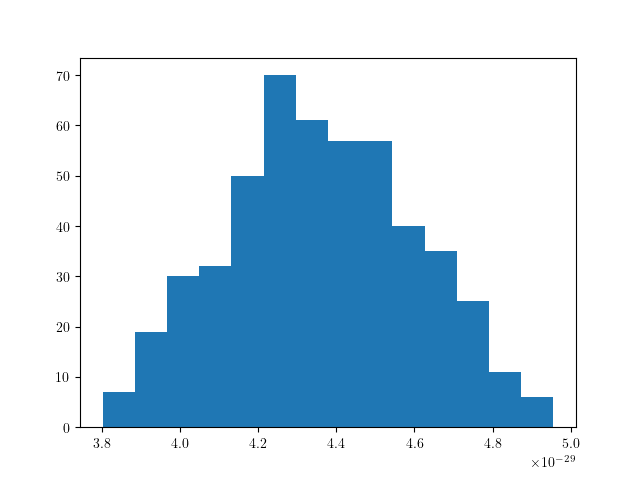

(array([ 7., 19., 30., 32., 50., 70., 61., 57., 57., 40., 35., 25., 11.,
         6.]),
 array([3.80204314e-29, 3.88446021e-29, 3.96687728e-29, 4.04929434e-29,
        4.13171141e-29, 4.21412847e-29, 4.29654554e-29, 4.37896261e-29,
        4.46137967e-29, 4.54379674e-29, 4.62621381e-29, 4.70863087e-29,
        4.79104794e-29, 4.87346500e-29, 4.95588207e-29]),
 <a list of 14 Patch objects>)

In [32]:
fig, ax = plt.subplots()
ax.hist(np.array(testkcorr)[:,0], bins="auto")

In [23]:
np.mean(testkcorr, axis=0)

array([4.36317990e-29, 5.13969792e-29, 7.13911096e-29, 1.77336015e-28,
       2.40339115e-28, 2.90015988e-28, 3.66581892e-28])

In [24]:
testres.data_kcorr

{'FUV': {'flux': 4.074852076849915e-29,
  'mag': (22.404181811455977, 0.0),
  'mag.err': 1.0428544907904804,
  'flux.err': 1.5649681924407176e-29},
 'NUV': {'flux': 4.619152960246324e-29,
  'mag': (22.33490320922005, 0.0),
  'mag.err': 0.025681339628858883,
  'flux.err': 3.1390632169113464e-32},
 'u': {'flux': 7.031193709060348e-29,
  'mag': (21.80884516108383, 0.0),
  'mag.err': 0.5535039144779947,
  'flux.err': 2.274681675717461e-29},
 'g': {'flux': 1.659279917604633e-28,
  'mag': (20.812398987094028, 0.0),
  'mag.err': 0.07850827401142979,
  'flux.err': 8.612673194374014e-31},
 'r': {'flux': 2.205646126899124e-28,
  'mag': (20.51830717341379, 0.0),
  'mag.err': 0.07809008744012047,
  'flux.err': 1.37065282391698e-30},
 'i': {'flux': 2.7279899322782395e-28,
  'mag': (20.26364765160946, 0.0),
  'mag.err': 0.09397498540695892,
  'flux.err': 2.5579004607034792e-30},
 'z': {'flux': 3.471968807842956e-28,
  'mag': (20.013291092244895, 0.0),
  'mag.err': 0.2231178828343161,
  'flux.err': 2

In [7]:
"Hz" in ("Hz", "Herz")

True

In [8]:
from astropy import units

In [9]:
test = 12
testu = units.m

In [12]:
test *= 2 * testu * units.s 

UnitTypeError: Cannot store quantity with dimension resulting from multiply function in a non-Quantity instance.

In [18]:
test = np.array([1, 2, 3, 4])

In [19]:
test = 2 * test * testu * units.s 
test

<Quantity [2., 4., 6., 8.] m s>

In [17]:
testres.p_res

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.037241960987646434,
   'units': 'redshift',
   'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0),
   'name': 'zred'},
  {'N': 1,
   'isfree': True,
   'init': 10000000000.0,
   'units': 'Solar masses formed',
   'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0),
   'name': 'mass'},
  {'N': 1,
   'isfree': True,
   'init': -0.5,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19),
   'name': 'logzsol'},
  {'N': 1,
   'isfree': True,
   'init': 0.6,
   'units': 'optical depth at 5500AA',
   'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0),
   'name': 'dust2'},
  {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index', 'name': 'sfh'},
  {'N': 1,
   'isfree': True,
   'init': 1,
   'units': 'Gyr',
   'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8),
   'name': 'tage'},
  {'N

In [18]:
len(testres.get_sed_wavelength())

5994

In [19]:
len(testres.data_sed)

5994

In [21]:
testres.p_res["chain"][-1000:, :].shape

(1000, 5)

In [6]:
test = testres.get_sed_error()

TypeError: Required argument 'object' (pos 1) not found

In [50]:
theta = testres.p_res["chain"][-500:, :]
mspec = np.empty((500, len(testres.get_sed_wavelength())))
for ii in range(500):
    mspec[ii], _, _ = testres.p_mod.mean_model(theta[ii], testres.p_obs, sps=testres.p_sps)

In [26]:
mspec.shape

(100, 5994)

<IPython.core.display.Javascript object>


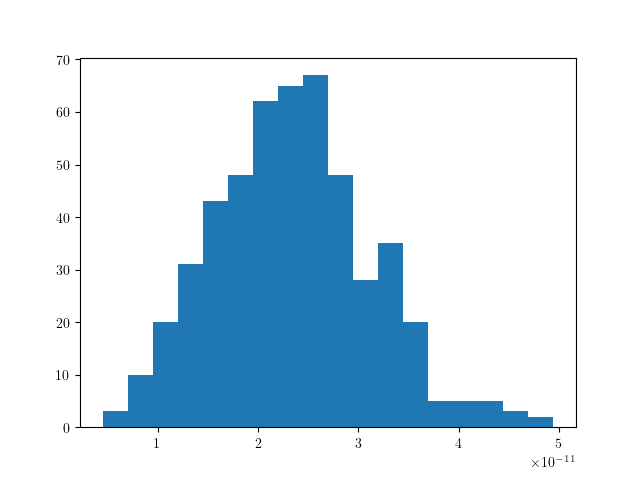

(array([ 3., 10., 20., 31., 43., 48., 62., 65., 67., 48., 28., 35., 20.,
         5.,  5.,  5.,  3.,  2.]),
 array([4.49843045e-12, 6.99670411e-12, 9.49497777e-12, 1.19932514e-11,
        1.44915251e-11, 1.69897987e-11, 1.94880724e-11, 2.19863461e-11,
        2.44846197e-11, 2.69828934e-11, 2.94811670e-11, 3.19794407e-11,
        3.44777143e-11, 3.69759880e-11, 3.94742617e-11, 4.19725353e-11,
        4.44708090e-11, 4.69690826e-11, 4.94673563e-11]),
 <a list of 18 Patch objects>)

In [51]:
fig, ax = plt.subplots()
ax.hist(mspec[:, -1], bins="auto")

In [44]:
np.mean(mspec, axis=0)

array([3.74832127e-17, 4.15410016e-17, 5.09986409e-17, ...,
       2.16138794e-11, 2.10417779e-11, 2.04989460e-11])

In [41]:
mspec.shape

(100, 5994)

In [9]:
from astropy import units


In [10]:
units.spectral_density(np.asarray([1500, 2000]) * units.AA)

[(Unit("erg / (Angstrom cm2 s)"),
  Unit("erg / (cm2 Hz s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter(x)>),
 (Unit("erg / (cm2 Hz s)"),
  Unit("erg / (cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_f_nu_to_nu_f_nu(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_f_nu_to_nu_f_nu(x)>),
 (Unit("erg / (Angstrom cm2 s)"),
  Unit("erg / (cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_f_la_to_la_f_la(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_f_la_to_la_f_la(x)>),
 (Unit("ph / (Angstrom cm2 s)"),
  Unit("erg / (Angstrom cm2 s)"),
  <function astropy.units.equivalencies.spectral_density.<locals>.converter_phot_f_la_to_f_la(x)>,
  <function astropy.units.equivalencies.spectral_density.<locals>.iconverter_phot_f_la_to_f_la(x)>),
 (U

In [34]:
testset = "continuity_flex_sfh"

from prospect.models.templates import TemplateLibrary
# Show all pre-defined parameter sets
TemplateLibrary.show_contents()
# Show details on the "parameteric" set of parameters
TemplateLibrary.describe(testset)
# Simply print all parameter specifications in "parametric_sfh"
print(TemplateLibrary[testset])

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set of parameters (most of which are free) for sampling the coefficients of a polynomial calibration vector.
'burst_sfh':
  The set of (fixed) parameters for an SF burst added to a parameteric SFH, with the burst time controlled by `fage_burst`.
'logm_sfh':
  Non-parameteric SFH fitting for log-mass in fixed time bins
'continuity_sfh'

In [35]:
import prospect.models as md

In [40]:
mdp = md.transforms

In [39]:
mdp.sfratio_to_sfr()

SyntaxError: invalid syntax (<ipython-input-39-1bce37f4f822>, line 1)